（参考）https://www.codexa.net/capsule-network-keras-mnist-tutorial/

In [3]:
# 必要なライブラリのインポート
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers

In [8]:
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers
 
# ベクトルの長さを計算する. margin_loss の y_true と同じサイズのテンソルを計算
class Length(layers.Layer):
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))
 
    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

In [9]:
# テンソルをマスクするクラス
class Mask(layers.Layer):
    def call(self, inputs, **kwargs):
        if type(inputs) is list: 
            assert len(inputs) == 2
            inputs, mask = inputs
        else:
            x = inputs
 
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)
 
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked
 
    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])

In [10]:
# 非線形の活性化関数
def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors

# カプセルレイヤー（カプセル層）の作成

* インプットのサイズ：[None, input_num_capsule, input_dim_vector] 
* アウトプットのサイズ：[None, num_capsule, dim_vector]

## パラメーター
* num_capsule：レイヤーのカプセル数
* dim_vector：レイヤーのカプセルベクトルの出力のディメンション
* num_routing：ルーティングアルゴリズムの反復回数

In [15]:
class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
 
    def build(self, input_shape):
        # 元のサンプルコードでは行末にカンマがあったが，除去した
        assert len(input_shape) >= 3
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]
 
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
                                 initializer=self.kernel_initializer,
                                 name='W')
 
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True
 
    def call(self, inputs, training=None):
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)
 
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])
 
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
 
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)
 
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
 
 
            if i != self.num_routing - 1:
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])
 
    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])
 
def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    output = layers.Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector])(output)
    return layers.Lambda(squash)(outputs)

In [16]:
# モデル構築
from keras import layers, models
from keras import backend as K
from keras.utils import to_categorical
def CapsNet(input_shape, n_class, num_routing):
    x = layers.Input(shape=input_shape)
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)
    primarycaps = PrimaryCap(conv1, dim_vector=8, n_channels=32, kernel_size=9, strides=2, padding='valid')
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=16, num_routing=num_routing, name='digitcaps')(primarycaps)
    out_caps = Length(name='out_caps')(digitcaps)
 
    y = layers.Input(shape=(n_class,))
    masked = Mask()([digitcaps, y])
    x_recon = layers.Dense(512, activation='relu')(masked)
    x_recon = layers.Dense(1024, activation='relu')(x_recon)
    x_recon = layers.Dense(784, activation='sigmoid')(x_recon)
    x_recon = layers.Reshape(target_shape=[28, 28, 1], name='out_recon')(x_recon)
 
    return models.Model([x, y], [out_caps, x_recon])

In [17]:
# マージンロスの処理
def margin_loss(y_true, y_pred):
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))
 
    return K.mean(K.sum(L, 1))

In [22]:
# モデルの宣言をしてモデルの概要をプリント
model = CapsNet(input_shape=[28, 28, 1],
                n_class=10,
                num_routing=3)
model.summary()
try:
    plot_model(model, to_file='model.png', show_shapes=True)
except Exception as e:
    print('No fancy plot {}'.format(e))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 1152, 8)      0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
lambda_5 (

MNIST読み込み＆カプセルネットワークの訓練

In [26]:
# mnist読み込み．　「ゼロから作るDeep Learning」のmnist.pyを利用
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import sys
import numpy as np


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = os.path.dirname(os.path.abspath(sys.argv[0]))
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
       _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """MNISTデータセットの読み込み
    
    Parameters
    ----------
    normalize : 画像のピクセル値を0.0~1.0に正規化する
    one_hot_label : 
        one_hot_labelがTrueの場合、ラベルはone-hot配列として返す
        one-hot配列とは、たとえば[0,0,1,0,0,0,0,0,0,0]のような配列
    flatten : 画像を一次元配列に平にするかどうか 
    
    Returns
    -------
    (訓練画像, 訓練ラベル), (テスト画像, テストラベル)
    """
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 


In [29]:
# CapsNet（カプセルネットワーク）のトレーニング
def train(model, data, epoch_size_frac=1.0):
 
    (x_train, y_train), (x_test, y_test) = data
 
    log = callbacks.CSVLogger('log.csv')
    checkpoint = callbacks.ModelCheckpoint('weights-{epoch:02d}.h5',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * np.exp(-epoch / 10.))
 
    model.compile(optimizer='adam',
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.0005],
                  metrics={'out_caps': 'accuracy'})
 
    # -----------------------------------Begin: Training with data augmentation -----------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction)
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])
 
    model.fit_generator(generator=train_generator(x_train, y_train, 64, 0.1),
                        steps_per_epoch=int(epoch_size_frac*y_train.shape[0] / 64),
                        epochs=1,
                        validation_data=[[x_test, y_test], [y_test, x_test]],
                        callbacks=[log, checkpoint, lr_decay])
    # -----------------------------------End: Training with data augmentation -----------------------------------#
 
    model.save_weights('trained_model.h5')
    print('Trained model saved to \'trained_model.h5\'')
 
    return model

In [58]:
# MNISTデータを読み込み，データを加工して，訓練させる
(x_train, t_train),(x_test, t_test)=load_mnist(flatten=True,normalize=False)
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
t_train = to_categorical(t_train.astype('float32'))
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255
t_test = to_categorical(t_test.astype('float32'))
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

train(model=model, data=((x_train, t_train), (x_test[:60], t_test[:60])), epoch_size_frac = 0.5)
#train(model=model, data=((x_train, t_train), (x_test, t_test)), epoch_size_frac = 0.5)

(60000, 784)
(60000,)
(10000, 784)
(10000,)
(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)
Epoch 1/1
468/468 [==============================] - 2099s 4s/step - loss: 0.1403 - out_caps_loss: 0.1402 - out_recon_loss: 0.1304 - out_caps_acc: 0.8570 - val_loss: 0.0344 - val_out_caps_loss: 0.0344 - val_out_recon_loss: 0.0636 - val_out_caps_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.03438, saving model to weights-01.h5
Trained model saved to 'trained_model.h5'


In [59]:
# 画像を簡単に処理する関数
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(np.sqrt(num))
    height = int(np.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image
 
def test(model, data):
    x_test, y_test = data
    y_pred, x_recon = model.predict([x_test, y_test], batch_size=100)
    print('-'*50)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])
 
    import matplotlib.pyplot as plt
    from PIL import Image
 
    img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save("real_and_recon.png")
    print()
    print('Reconstructed images are saved to ./real_and_recon.png')
    print('-'*50)
    plt.imshow(plt.imread("real_and_recon.png", ))
    plt.show()

--------------------------------------------------
Test acc: 0.965

Reconstructed images are saved to ./real_and_recon.png
--------------------------------------------------


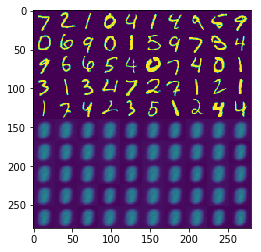

In [66]:
# CapsNetのテスト
# テスト用データの最初の1000件を使う
test(model=model, data=(x_test[:1000], t_test[:1000]))